<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/UV_Stellar_Catalog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install**

In [1]:
!pip install git+https://github.com/rlwastro/mastcasjobs@master --quiet
!pip install git+https://github.com/astrofrog/sedfitter@master --quiet

     |████████████████████████████████| 10.8 MB 4.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


# **GitHub**

In [43]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 746, done.
remote: Counting objects: 100% (371/371), done.
remote: Compressing objects: 100% (367/367), done.
remote: Total 746 (delta 207), reused 4 (delta 2), pack-reused 375
Receiving objects: 100% (746/746), 89.48 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (395/395), done.


In [73]:
cd INSIST/data

[Errno 2] No such file or directory: 'INSIST/data'
/content/INSIST/data


In [45]:
!cp -a plot.py /usr/local/lib/python3.7/dist-packages/sedfitter

#**Imports**

In [72]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from astropy.table import Table
from astropy.io import fits

import os
from time import perf_counter
import json
import requests
import sedfitter as sed

import mastcasjobs
from scipy.optimize import minimize_scalar,minimize

# get the WSID and password if not already defined
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = "avinashck90"
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = "INSIST369"

matplotlib.rcParams['font.size']=15
matplotlib.rcParams['figure.figsize']=(15,10)
sb.set_style('darkgrid')

# **Data**

## **CasJobs Script**

In [ ]:
def mastQuery(request, json_return=False):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    
    Returns the text response or (if json_return=True) the json response
    """
    
    url = "https://mast.stsci.edu/api/v0/invoke"

    # Encoding the request as a json string
    requestString = json.dumps(request)
    
    # make the query
    r = requests.post(url, data=dict(request=requestString))
    
    # raise exception on error
    r.raise_for_status()
    
    if json_return:
        return r.json()
    else:
        return r.text


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObject = mastQuery(resolverRequest, json_return=True)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

In [ ]:
class casjobs():
    """PSF Generator using Source catalog or CasJobs GALEX Catalog

    Parameters
    ----------
    name (string) : Catalog name or coordinates of the source

    df   (pd.DataFrame ): Pandas dataframe with source catalog

    cols (dict) : dict object with column name conversions for ra,dec,mag_nuv. Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

        'ra' (degrees)

        'dec' (degrees)

        'mag_nuv' (ABmag)

    pixel_scale (float) : pixel scale of detector in the unit of arcseconds/pixels

    fwhm_in (float) : Full Width at Half Maximum of the Gaussian PSF

    n_pix_main (int) : Number of pixels along one axis in the detector. Total number of pixels in the detector is n_pix_main**2

    n_pix_sub (int) : Number of pixels along one axis in the path. Total number of pixels in the patch is n_pix_sub**2

    """
    def __init__(self,name = None, df = None ,cols = None):   

        if name is not None and df is None:
          self.name = name
          self.ra,self.dec = resolve(name)
      
          self.jobs = mastcasjobs.MastCasJobs(context="PanSTARRS_DR2")
          self.query =   f"""select psc.objid,o.raStack,o.decStack,mag.gPSFMag, mag.gPSFMagErr,mag.rPSFMag, mag.rPSFMagErr,mag.iPSFMag, mag.iPSFMagErr,mag.zPSFMag,mag.zPSFMagErr, mag.yPSFMag,mag.yPSFMagErr,psc.ps_score
                            from fGetNearbyObjEq({self.ra}, {self.dec}, 28) f
                            join ObjectThin o on o.objid=f.objid
                            join HLSP_PS1_PSC.pointsource_scores psc on psc.objid=f.objid
                            join StackObjectThin mag on mag.objid=psc.objid
                            WHERE
                            mag.gPSFMag>-900 and 
                            mag.rPSFMag>-900 and 
                            mag.iPSFMag>-900 and 
                            mag.zPSFMag>-900 and 
                            mag.yPSFMag>-900 
                          """
          self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas()
        else:
          self.df = df 
        if cols is not None:
          self.df = self.df.rename(columns=cols) 
    
    def show_field(self,figsize=(10,10)):
      """
      Function for creating a scatter plot of sources within the FoV
      
      Returns
      -------
      fig, ax
      """
        
      fig, ax = plt.subplots(1,1,figsize=figsize)
      ax.scatter(self.df['ra'],self.df['dec'],marker='.',color='black')
      ax.set_title(f" Requested Center : {self.name} \n  {len(self.df)} sources")
      ax.invert_xaxis()
      ax.set_xlabel('RA (Degrees)')
      ax.set_ylabel('Dec (Degrees)')
      return fig,ax
      
        

## **Query**

In [ ]:
df = pd.read_csv('M67_PS1.csv')
df =  df.rename(columns = {'raStack':'ra','decStack':'dec'})

In [ ]:
df_star = df[df['ps_score']>0.5].copy()[:100]

# **M 31**

In [5]:
df_M31 = Table.read('M31_UVIT_PanSTARRS_crossmatch.fits').to_pandas()

In [137]:
df_star = df_M31[df_M31['ps_score']>0.5][:10].copy()
df_star =  df_star.rename(columns = {'raStack':'ra','decStack':'dec'})

In [138]:
df_star

,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,Filt1,Filt2,RAJ2000,DEJ2000,ABmag1,mag1,Errmag1,Field1,RA2deg,DE2deg,ABmag2,mag2,Errmag2,Field2,Sep,Separation
0,157340109227129762,10.922739,41.124300,19.166800,0.006854,19.014500,0.007228,19.201599,0.006759,19.291201,0.018884,19.500000,0.030220,0.980958,b'FUVCaF2 ',b'NUVN2 ',10.9228,41.1242,22.156,19.755,0.124,b'1 ',10.9227,41.1243,20.267,18.767,0.145,b'1 ',0.33,0.395743
1,157350108218814598,10.821905,41.128297,19.927500,0.011572,19.940701,0.013347,20.227200,0.015063,20.469200,0.058316,21.181499,0.179356,0.754958,b'FUVCaF2 ',b'NUVN2 ',10.8219,41.1283,22.973,20.572,0.189,b'1 ',10.8219,41.1283,20.959,19.459,0.207,b'1 ',0.08,0.017808
9,157370109140545982,10.914085,41.146146,19.370600,0.007357,19.448799,0.007755,19.645700,0.009382,19.651600,0.022474,19.953100,0.047216,0.878381,b'FUVCaF2 ',b'NUVN2 ',10.9140,41.1461,21.984,19.583,0.114,b'1 ',10.9140,41.1462,20.669,19.169,0.176,b'1 ',0.24,0.284070
12,157370109233994618,10.923382,41.144935,20.432600,0.015134,20.618200,0.021923,20.797400,0.024957,21.109900,0.089870,21.309000,0.171389,0.827542,b'FUVCaF2 ',b'NUVN2 ',10.9234,41.1449,21.955,19.554,0.112,b'1 ',10.9234,41.1449,20.833,19.333,0.187,b'1 ',0.08,0.134448
15,157380108253555129,10.825354,41.153794,20.025299,0.012747,20.400499,0.019732,20.898899,0.029436,21.675200,0.161203,22.522200,0.547691,0.742468,b'FUVCaF2 ',b'NUVN2 ',10.8254,41.1538,21.068,18.667,0.078,b'1 ',10.8253,41.1538,19.989,18.489,0.129,b'1 ',0.14,0.126107
16,157380109041666548,10.904230,41.155025,20.680901,0.020027,21.081699,0.035581,21.052099,0.038105,21.200899,0.109916,20.672199,0.094312,0.662577,b'FUVCaF2 ',b'NUVN2 ',10.9044,41.1549,20.982,18.581,0.077,b'1 ',10.9043,41.1549,20.423,18.923,0.156,b'1 ',0.22,0.644070
17,157380109152072565,10.915229,41.151610,19.637100,0.008957,19.394400,0.008442,19.478201,0.008784,19.429001,0.018646,19.729099,0.044062,0.982000,b'FUVCaF2 ',b'NUVN2 ',10.9152,41.1516,22.216,19.815,0.129,b'1 ',10.9152,41.1515,20.471,18.971,0.158,b'1 ',0.23,0.086737
21,157380109682042534,10.968279,41.151657,20.176800,0.014718,20.649500,0.031072,20.860201,0.025429,20.725201,0.057236,20.750299,0.103234,0.908333,b'FUVCaF2 ',b'NUVN2 ',10.9682,41.1516,20.445,18.044,0.047,"b'1, 7 '",10.9682,41.1516,19.935,18.435,0.092,"b'1, 7 '",0.14,0.298064
22,157390108841348391,10.884237,41.164827,19.809000,0.010636,19.623899,0.010883,19.896900,0.013037,19.758699,0.028134,20.024599,0.048989,0.723396,b'FUVCaF2 ',b'NUVN2 ',10.8842,41.1648,20.654,18.253,0.068,b'1 ',10.8842,41.1648,19.753,18.253,0.115,b'1 ',0.19,0.140736
23,157390108898417576,10.889968,41.164172,20.032000,0.012276,20.002300,0.014587,20.626900,0.021584,21.151501,0.091410,20.598000,0.083246,0.824387,b'FUVCaF2 ',b'NUVN2 ',10.8900,41.1642,20.115,17.714,0.056,b'1 ',10.8900,41.1642,19.719,18.219,0.116,b'1 ',0.02,0.132102


# **Synthetic Spectra**

## **Model**

In [52]:
if os.path.exists('models_kurucz'):
  os.system('rm -r models_kurucz')

In [53]:
!curl -o models ftp://ftp.astro.wisc.edu/outgoing/tom/model_packages/models_kurucz_05sep11.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 83.0M  100 83.0M    0     0  7203k      0  0:00:11  0:00:11 --:--:-- 12.2M


In [54]:
!tar -xzf models

In [55]:
!rm models

## **Filters**

Initializing filter parameters using response curves

In [95]:
filter_dict = {'PS1g'    : [4881.47, 'PAN-STARRS_PS1.g.dat' ],
               'PS1r'    : [6198.41, 'PAN-STARRS_PS1.r.dat' ],
               'PS1i'    : [7549.34, 'PAN-STARRS_PS1.i.dat' ],
               'PS1z'    : [8701.37, 'PAN-STARRS_PS1.z.dat' ],
               'PS1y'    : [9509.80,'PAN-STARRS_PS1.y.dat' ],
               'UVIT_NUV': [2792.56,'Astrosat_UVIT.N279N.dat'],
               'UVIT_FUV': [1506.00,'Astrosat_UVIT.F148Wa.dat']}

model_dir = 'models_kurucz'
filter_list = []
for filter in filter_dict.keys():

  filt_obj = sed.filter.Filter()
  filt_obj.name = filter
  filt_obj.central_wavelength = (filter_dict[filter][0]*u.angstrom).to(u.micron)
  filt_obj_wl, filt_obj_rsr = np.loadtxt(filter_dict[filter][1], usecols=(0, 1), unpack=True)
  filt_obj.nu = 3.0e18 * u.Hz / np.flip(filt_obj_wl)
  filt_obj_rsr = np.flip(filt_obj_rsr)
  filt_obj.response = filt_obj_rsr/filt_obj_rsr.max() 
  filt_obj.normalize()
  filter_list.append(filt_obj)

Convolving filters with models

In [96]:
sed.convolve.convolve_model_dir(model_dir, filter_list)

INFO: 3808 SEDs found in models_kurucz [sedfitter.convolve.convolve]
INFO: Rebinning filters [sedfitter.convolve.convolve]


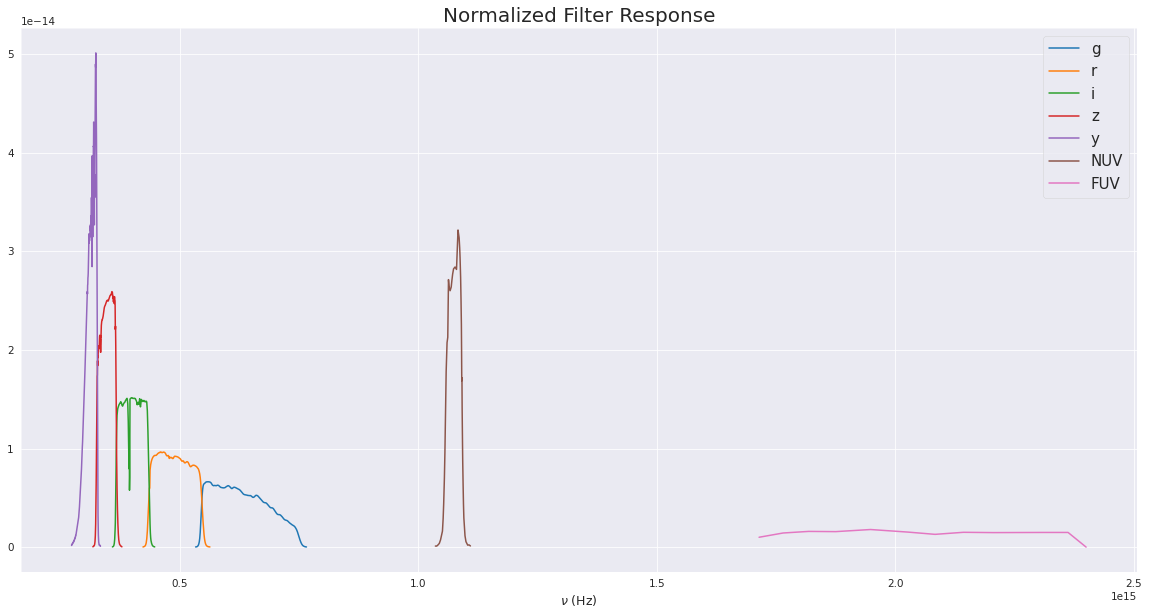

In [60]:
plt.figure(figsize = (20,10))
for filter in filter_list:
  plt.plot(filter.nu, filter.response)

plt.xlabel(r'$\nu$ (Hz)')
plt.title('Normalized Filter Response',size=20)
plt.legend(['g','r','i','z','y' ,'NUV','FUV'])


## **SED Fitting**

### **SED Fitter**

#### **Without UV**

In [210]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)*1000            #mJy

  df_star[f'{i}PSFFlux_err'] = (df_star[f'{i}PSFMagErr']*df_star[f'{i}PSFFlux'])/1.09  #mJy

df_star['g_flag']  = 1
df_star['i_flag']  = 1
df_star['r_flag']  = 1
df_star['z_flag']  = 1
df_star['y_flag']  = 1

df_star = df_star.drop_duplicates('objid')

df_out = df_star[['objid', 'ra', 'dec','g_flag', 'i_flag', 'r_flag', 'z_flag','y_flag','gPSFFlux','gPSFFlux_err','rPSFFlux', 'rPSFFlux_err','iPSFFlux', 'iPSFFlux_err','zPSFFlux', 'zPSFFlux_err','yPSFFlux', 'yPSFFlux_err']]

df_out.to_csv('data_input.dat', sep = " ",index=False, header=False)

In [211]:
model_dir = 'models_kurucz'

# Read in extinction law)
extinction = sed.Extinction.from_file('kmh94.par', columns=[0, 3],
                                  wav_unit=u.micron, chi_unit=u.cm**2 / u.g)

# Define filters and apertures
filters = ['PS1g', 'PS1r', 'PS1i', 'PS1z', 'PS1y']
apertures = [3., 3., 3., 3., 3.] * u.arcsec

# Run the fitting
d = sed.fit('data_input.dat', filters, apertures, model_dir, 'output.fitinfo', extinction_law=extinction, distance_range=[0.01, 2.] * u.Mpc,av_range=[0., 40.],output_convolved=True)

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  Kurucz stellar photospheres
   Log[d] stepping     :  0.02

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

   Reading models_kurucz/convolved/PS1g.fits
   Reading models_kurucz/convolved/PS1r.fits
   Reading models_kurucz/convolved/PS1i.fits
   Reading models_kurucz/convolved/PS1z.fits
   Reading models_kurucz/convolved/PS1y.fits
 ------------------------------------------------------------
  => Fitting parameters
 ------------------------------------------------------------

   Minimum A_V      :     0.000 mag
   Maximum A_V      :    40.000 mag
   Minimum distance :     0.010 Mpc
   Maximum distance :     2.000 Mpc

 ------------------------------------------------------------
  => Output parameters
 ----


Extracting fitting parameters from SED Fitter output

In [212]:
from sedfitter import plot
plot('output.fitinfo', 'plots_seds',format='png' , dpi = 1024)

Delete directory plots_seds? [y/[n]] y



In [213]:
fin = sed.FitInfoFile('output.fitinfo', 'r')
modpar = sed.utils.parfile.read("%s/models.conf" % fin.meta.model_dir, 'conf')

f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)
FUV = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1) 


flux     = []
flux_err = []
chi2     = []
Avs      = []
scs      = []

model_names = []
for info in fin:
  Avs.append(info.av[0])
  scs.append(info.sc[0])
  model_name = info.model_name[0]
  model_names.append(model_name)
  chi2.append(info.chi2[0])

  g = [f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  r = [f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  i = [f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  z = [f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  y = [f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  fuv =[FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  flux.append([fuv[0], g[0], r[0], i[0], z[0], y[0]])

  flux_err.append([fuv[1],g[1], r[1], i[1], z[1], y[1]])

flux = np.array(flux)

flux_err = np.array(flux_err)

Avs = np.array(Avs)

scs = np.array(scs)

Text(0.5, 1.0, 'SED Fitter')

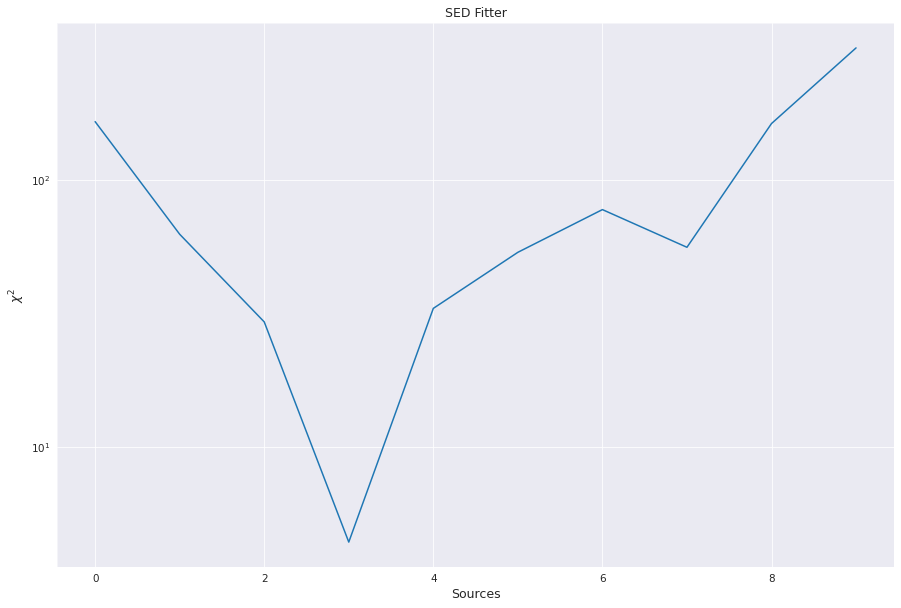

In [214]:
plt.plot(chi2)
plt.yscale('log')
plt.ylabel(r'$\chi^2$')
plt.xlabel('Sources')
plt.title('SED Fitter')

#### **With UV**

In [188]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)*1000            #mJy

  df_star[f'{i}PSFFlux_err'] = (df_star[f'{i}PSFMagErr']*df_star[f'{i}PSFFlux'])/1.09  #mJy


df_star['FUVFlux'] = 3631*pow(10,-df_star['ABmag1']/2.5)*1000 
df_star['FUVFlux_err'] = (df_star['Errmag1']*df_star['FUVFlux'])/1.09  #mJy 

df_star['NUVFlux'] = 3631*pow(10,-df_star['ABmag2']/2.5)*1000 
df_star['NUVFlux_err'] = (df_star['Errmag2']*df_star['NUVFlux'])/1.09  #mJy 

df_star['fuv_flag']  = 1
df_star['nuv_flag']  = 1
df_star['g_flag']  = 1
df_star['i_flag']  = 1
df_star['r_flag']  = 1
df_star['z_flag']  = 1
df_star['y_flag']  = 1

df_star = df_star.drop_duplicates('objid')

df_out = df_star[['objid', 'ra', 'dec','fuv_flag','nuv_flag','g_flag', 'i_flag', 'r_flag', 'z_flag','y_flag','FUVFlux','FUVFlux_err','NUVFlux','NUVFlux_err','gPSFFlux','gPSFFlux_err','rPSFFlux', 'rPSFFlux_err','iPSFFlux', 'iPSFFlux_err','zPSFFlux', 'zPSFFlux_err','yPSFFlux', 'yPSFFlux_err']]

df_out.to_csv('data_input.dat', sep = " ",index=False, header=False)

In [ ]:
model_dir = 'models_kurucz'

# Read in extinction law)
extinction = sed.Extinction.from_file('kmh94.par', columns=[0, 3],
                                  wav_unit=u.micron, chi_unit=u.cm**2 / u.g)

# Define filters and apertures
filters = ['UVIT_FUV', 'UVIT_NUV','PS1g', 'PS1r', 'PS1i', 'PS1z', 'PS1y']
apertures = [1.8,1.8, 1.51, 1.39, 1.34, 1.27, 1.21] * u.arcsec

# Run the fitting
d = sed.fit('data_input.dat', filters, apertures, model_dir, 'output.fitinfo', extinction_law=extinction, distance_range=[0.01, 2.] * u.Mpc,av_range=[0., 10.],output_convolved=True)


Extracting fitting parameters from SED Fitter output

In [198]:
from sedfitter import plot
plot('output.fitinfo', 'plots_seds_UV',format='png' , dpi = 1024)

Delete directory plots_seds? [y/[n]] y



In [201]:
fin = sed.FitInfoFile('output.fitinfo', 'r')
modpar = sed.utils.parfile.read("%s/models.conf" % fin.meta.model_dir, 'conf')


FUV = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1) 
NUV = Table.read('models_kurucz/convolved/UVIT_NUV.fits',hdu=1) 

f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)

flux     = []
flux_err = []
chi2     = []
Avs      = []
scs      = []

model_names = []
for info in fin:
  Avs.append([info.av[0]]*7)
  scs.append([info.sc[0]]*7)
  model_name = info.model_name[0]
  model_names.append(model_name)
  chi2.append(info.chi2[0])

  fuv =[FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  nuv =[NUV[NUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , NUV[NUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  g = [f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  r = [f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  i = [f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  z = [f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  y = [f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]


  flux.append([fuv[0], nuv[0],  g[0], r[0], i[0], z[0], y[0]])

  flux_err.append([fuv[1], nuv[1], g[1], r[1], i[1], z[1], y[1]])

flux = np.array(flux)

flux_err = np.array(flux_err)

Avs = np.array(Avs)

scs = np.array(scs)

Text(0.5, 1.0, 'SED Fitter')

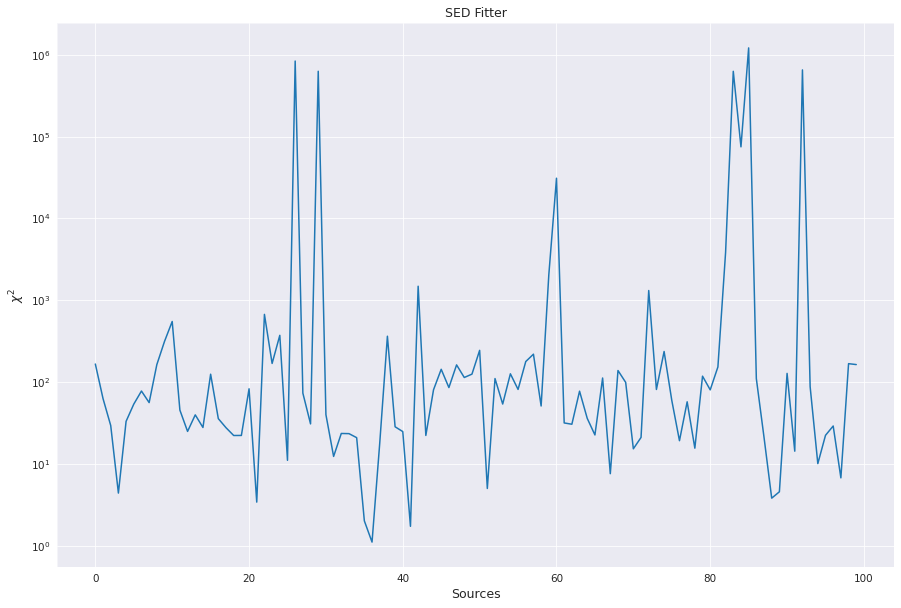

In [107]:
plt.plot(chi2)
plt.yscale('log')
plt.ylabel(r'$\chi^2$')
plt.xlabel('Sources')
plt.title('SED Fitter')

### **SED Fitting Routine**

EMCEE : Bayesian. 

#### **Data**

In [80]:
df_star = df_star.reset_index()

In [81]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)*1000            #mJy

  df_star[f'{i}PSFFlux_err'] = (df_star[f'{i}PSFMagErr']*df_star[f'{i}PSFFlux'])/1.09  #mJy

#### **Without Av**

In [ ]:
def chi2_func(Md,flux,model_flux,flux_err):
  chi = (flux - Md*model_flux)/flux_err
  return chi@chi

In [ ]:
# Convolved Filters

f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)['TOTAL_FLUX'].value[:,0]

model_name = [ i  for i in Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['MODEL_NAME']]
chi_set = []

# Chi2 loop : Takes about 5 minutes with current settings
for i,row in df_star.iterrows():
  flux     = row[['gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux']].values
  flux_err = row[['gPSFFlux_err', 'rPSFFlux_err', 'iPSFFlux_err', 'zPSFFlux_err']].values

  for j,model_flux in enumerate(zip(f1,f2,f3,f4)):
    model_flux = np.array(model_flux)
    
    Md = minimize_scalar(chi2_func,args=(flux,model_flux,flux_err)).x
    
    chi2   = chi2_func(Md,flux,model_flux,flux_err)
    chi_set.append([row['objid'],model_name[j],Md,chi2])

In [ ]:
df_chi = pd.DataFrame(chi_set, columns = ['objid','model_name','Md','chi2'])

#### **With Av**

$\chi^2 =\dfrac{1}{N - n_p}\sum\limits_{i=1}^j\left(\dfrac{Y_{i,o} -M_d \times Y_{i,M}\times10^{-0.4\times ext_i\times A_v}}{\sigma_{i,o}}\right)^2$

In [60]:
def chi2_func(params,flux,model_flux,flux_err,ext):
  Md, av = params
  chi = (flux - Md*model_flux*pow(10,-0.4*av*ext))/flux_err
  return chi@chi

In [61]:
# Convolved Filters

f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)['TOTAL_FLUX'].value[:,0]

model_name = [ i  for i in Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['MODEL_NAME']]
ext = np.array([1.18, 0.881, 0.667, 0.534,0.457])
chi_set = []

# Chi2 loop : Takes about 5 minutes with current settings
for i,row in df_star.iterrows():
  flux     = row[['gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux', 'yPSFFlux']].values
  flux_err = row[['gPSFFlux_err', 'rPSFFlux_err', 'iPSFFlux_err', 'zPSFFlux_err', 'yPSFFlux_err']].values

  for j,model_flux in enumerate(zip(f1,f2,f3,f4,f5)):
    model_flux = np.array(model_flux)
    
    params = minimize(chi2_func,x0 = (1e-2,0.5),bounds=([0,np.inf],[0,np.inf]),args=(flux,model_flux,flux_err,ext)).x
    Md, Av = params
    chi2   = chi2_func(params,flux,model_flux,flux_err,ext)
    chi_set.append([row['objid'],model_name[j],Md,Av,chi2])

In [62]:
df_chi = pd.DataFrame(chi_set, columns = ['objid','model_name','Md','Av','chi2'])

#### **Minimize chi**

In [63]:
df_chi_min = df_chi[0:0]
for i in df_chi['objid'].unique():
  df_temp = df_chi[ df_chi['objid'] == i]
  df_chi_min = df_chi_min.append(df_temp[df_temp['chi2']==df_temp['chi2'].min()])

In [64]:
df_chi_min 

,objid,model_name,Md,Av,chi2
1514,157340109227129762,kt07750g+5.0z+0.5,0.005458,0.011774,163.507443
5594,157350108218814598,kt08750g+5.0z+0.5,0.001595,0.000000,81.514517
9210,157370109140545982,kt08250g+1.0z+0.5,0.003258,0.036439,33.166431
14842,157370109233994618,kt31000g+3.5z+0.5,0.000183,0.859586,4.119895
18674,157380108253555129,kt31000g+5.0z+0.5,0.000114,0.000092,48.453917
...,...,...,...,...,...
365010,157500109945884951,kt26000g+3.0z+0.5,0.000382,0.470004,45.902579
367010,157500110013222746,kt07500g+5.0z+0.5,0.004401,0.082608,36.385458
370751,157500110272453951,kt07500g+0.5z-2.5,0.002251,0.790770,6.476241
375918,157500110440108541,kt14000g+3.0z-2.0,0.000434,0.000000,133.128799


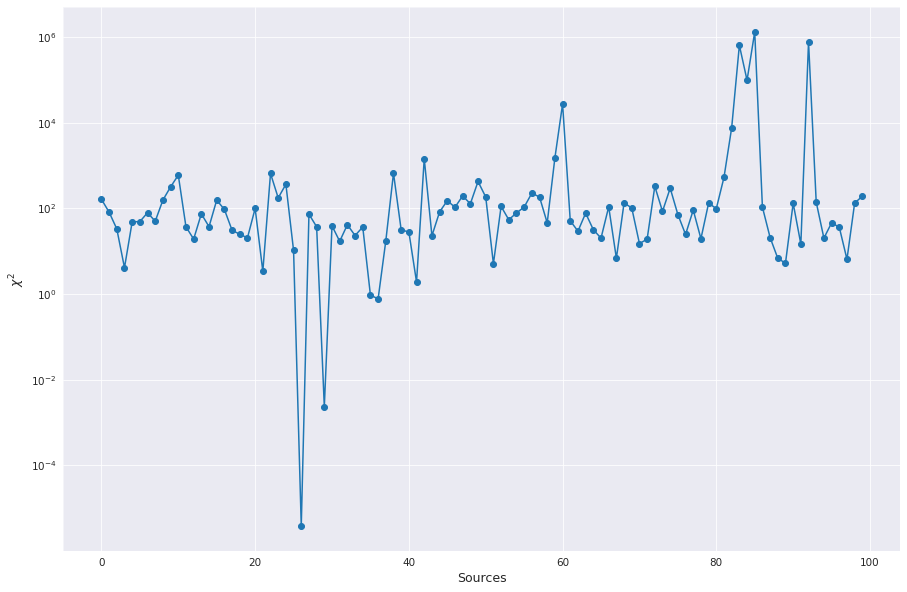

In [91]:
plt.plot(df_chi_min['chi2'].values,'o-')
plt.ylabel(r'$\chi^2$')
plt.xlabel('Sources')
plt.yscale('log')

In [76]:
FUV = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1) 
NUV = Table.read('models_kurucz/convolved/UVIT_NUV.fits',hdu=1) 
f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)


flux     = []
flux_err = []
model_names = []
for i,row in df_chi_min.iterrows():
  model_name = row['model_name']

  fuv =[FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  nuv =[NUV[NUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , NUV[NUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  g = [f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  r = [f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  i = [f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  z = [f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  y = [f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  fuv =[FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  flux.append([fuv[0], nuv[0], g[0], r[0], i[0], z[0], y[0]])

  flux_err.append([fuv[1], nuv[1], g[1], r[1], i[1], z[1], y[1]])

flux = np.array(flux)

flux_err = np.array(flux_err)

In [82]:
tab_star = Table.from_pandas(df_star)

tab_star['model_flux']     = flux
tab_star['Md']             = df_chi_min['Md']
tab_star['Av']             = df_chi_min['Av']

model_mag = []
ext = np.array([2.67,1.95, 1.18, 0.881, 0.667, 0.534,0.457])

for row in tab_star:
  Av = row['Av']
  Md = row['Md']
  model_flux = row['model_flux']

  model_mag.append(-2.5*np.log10(Md*model_flux*pow(10,-0.4*ext*Av)/3631e3))

tab_star['model_mag']  = model_mag
tab_star['chi2'] = df_chi_min['chi2']

In [92]:
filters = ['ABmag1','ABmag2','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag']

x = ['FUV', 'NUV', 'gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag']

FUV_diff = []
FUV_obs = []

NUV_diff = []
NUV_obs = []
for i,fl in df_star[filters].iterrows():
  #plt.plot(x,fl, 'o-', color = 'black')
  #plt.plot(x,tab_star['model_mag'].value[i],'s--')
  FUV_obs.append(fl[0])
  FUV_diff.append(fl[0] - tab_star['model_mag'].value[i][0])

  NUV_obs.append(fl[1])
  NUV_diff.append(fl[1] - tab_star['model_mag'].value[i][1])
 # plt.legend(['Observed','Model'])
 # plt.show()

Text(0.5, 1.0, 'SED Fitting with Md and Av')

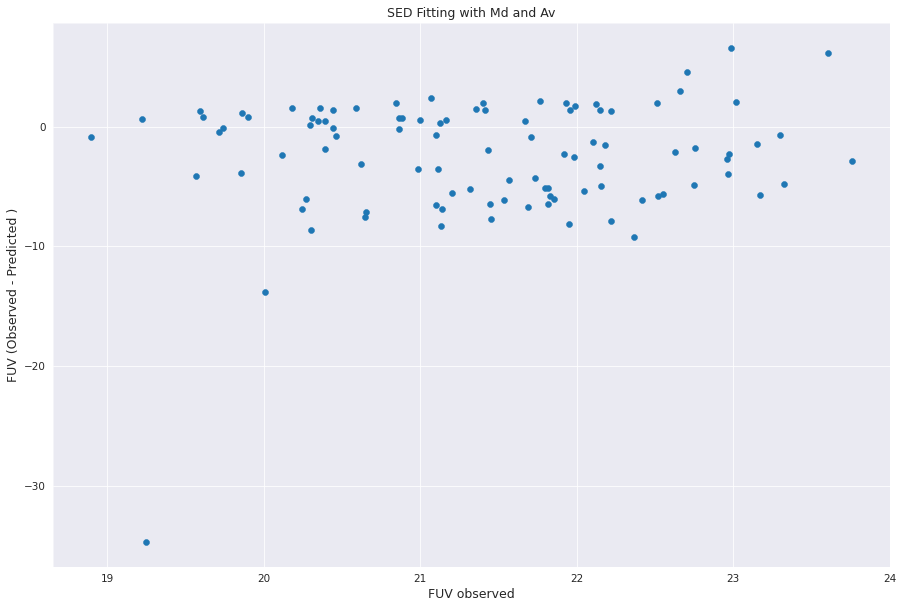

In [93]:
plt.scatter(FUV_obs,FUV_diff)
plt.ylabel('FUV (Observed - Predicted )')
plt.xlabel('FUV observed')
plt.title('SED Fitting with Md and Av')


Text(0.5, 1.0, 'SED Fitting with Md and Av')

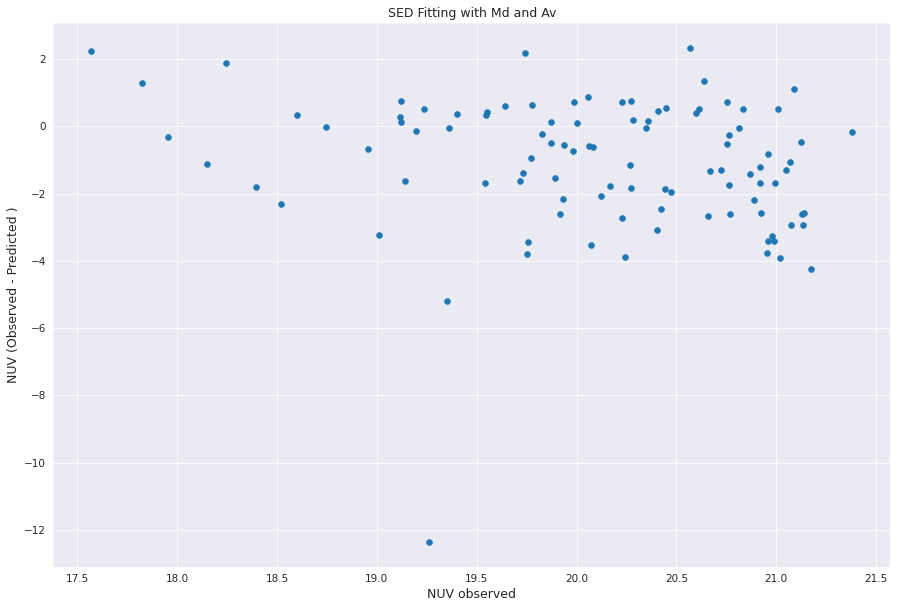

In [90]:
plt.scatter(NUV_obs,NUV_diff)
plt.ylabel('NUV (Observed - Predicted )')
plt.xlabel('NUV observed')
plt.title('SED Fitting with Md and Av')


In [ ]:
df_chi_min['chi2']

1383         8.365718
7602        26.792365
9178         2.553384
12807       40.971728
16602       11.043201
             ...     
363969     107.093313
367018     187.890014
370831      16.210884
376626       3.292204
380786    1508.570969
Name: chi2, Length: 100, dtype: float64